In [704]:
# Objective is to predict the demand for bikes using relevant inputs from the data set

In [705]:
# Importing the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from statsmodels.graphics.gofplots import qqplot

In [706]:
# Reading and viewing the data
bike_data = pd.read_csv("day.csv")
bike_data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [707]:
# Information regarding the data
bike_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [708]:
# From the above data we can see that there are no missing values in the dataset

In [709]:
# Listing down the set of variables
# a) Ordered categorical
    # 1) year
    # 2) weekday
ordered_cat = ["yr","weekday"] # ordered categorical columns
# b) Unordered categorical
    # 1) holiday
    # 2) working day
    # 3) weathersit
unordered_cat = ["holiday","workingday","weathersit"] # unordered categorical columns
# c) Numerical
    # 1) atemp
    # 2) hum
    # 3) windspeed
num_columns = ["atemp","hum","windspeed"] # numerical columns
# d) Cyclic variables
    # 1) season 

In [710]:
# Class for EDA analysis
class EDA:

    def box_plot(self,data,feat):
        plt.figure(figsize=(15,10))
        plt.boxplot(bike_data[feat],labels=feat)
        plt.xlabel("Variable",fontsize=12)
        plt.ylabel("Value",fontsize=12)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.show()  

    def box_plot_cat(self,data,feat):
        plt.figure(figsize=(15,10))
        sns.boxplot(x=feat,y="cnt",data=data)
        plt.xlabel(feat,fontsize=12)
        plt.ylabel("cnt",fontsize=12)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.show() 
    
    def detect_outliers(self,data):
        quantiles = data[num_columns].quantile([0.25,0.75])
        for i in num_columns:
            iqr = quantiles.loc[0.75,i]- quantiles.loc[0.25,i]
            lower_range = quantiles.loc[0.25,i] - 1.5*iqr
            upper_range = quantiles.loc[0.75,i] + 1.5*iqr
            outliers = data[(data[i]<lower_range) | (data[i]>upper_range)][i]
            print("Number of outliers in column ",i," are ",len(outliers))

    def remove_outliers(self,data):
        quantiles = data[num_columns].quantile([0.25,0.75])
        for i in num_columns:
            iqr = quantiles.loc[0.75,i]- quantiles.loc[0.25,i]
            lower_range = quantiles.loc[0.25,i] - 1.5*iqr
            upper_range = quantiles.loc[0.75,i] + 1.5*iqr
            outliers = data[(data[i]<lower_range) | (data[i]>upper_range)][i]
            if len(outliers)>0:
                print("Removing ", len(outliers), " outliers in column ",i)
                data = data[(data[i]>lower_range) & (data[i]<upper_range)]
        print("The number of data points after removing outliers are: ",len(data))
        return data

    def plot_corr(self,data):
        corr_mat = data.corr()
        plt.figure(figsize=(20,20))
        blue_map  = sns.color_palette("Blues", as_cmap=True)
        sns.heatmap(corr_mat,cmap=blue_map,annot=True)
        plt.show()

    def plot_scatter(self,data):
        for i in num_columns:
            plt.figure(figsize=(15,10))
            plt.scatter(data[i],data["cnt"])
            plt.xlabel(i,fontsize=12)
            plt.ylabel("cnt",fontsize=12)
            plt.xticks(fontsize=12)
            plt.yticks(fontsize=12)
            plt.show()

    def plot_scatter_with_removed(self,data,feature_name,removed_points):
        plt.figure(figsize=(15,10))
        plt.scatter(data[feature_name],data["cnt"])
        plt.scatter(removed_points[:,0],removed_points[:,1],color="red",linewidths=2)
        plt.xlabel(feature_name,fontsize=12)
        plt.ylabel("cnt",fontsize=12)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.legend(["Points considered","Points removed"],fontsize=14)
        plt.show()   
        print("The number of points remaining after removing the outliers are ",len(data))

    def plot_bar(self,data,features):
        feat_map_dict = {"yr":["2018","2019"],"weekday":["0","1","2","3","4","5","6"],"holiday":["0","1"],"workingday":["0","1"],"weathersit":["1","2","3"],"season":["spring","summer","fall","winter"]}
        for i in features:
            plt.figure(figsize=(15,10))
            axes = sns.barplot(x=i,y="cnt",data=data,estimator=sum,ci=None)
            axes.set_xticklabels(feat_map_dict[i])
            plt.xlabel(i,fontsize=12)
            plt.ylabel("Sum of cnt",fontsize=12)
            plt.xticks(fontsize=12)
            plt.yticks(fontsize=12)
            plt.show()

    

In [711]:
# From the data information it is evident that there are no missing values

# From the data dictionary
# 1) It can be inferred that instant can be dropped as it is just a record number
# 2) dteday can be dropped as information is already present in year and month
# 3) casual and registered can be dropped as they are not available before hand 
bike_data.drop(["instant","dteday","casual","registered"],axis=1,inplace=True)


In [712]:
# Displaying statistical information of the data
bike_data.describe()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,4508.006849
std,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,1936.011647
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,22.000000
25%,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,3169.750000
50%,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,4548.500000
75%,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,5966.000000
max,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,8714.000000


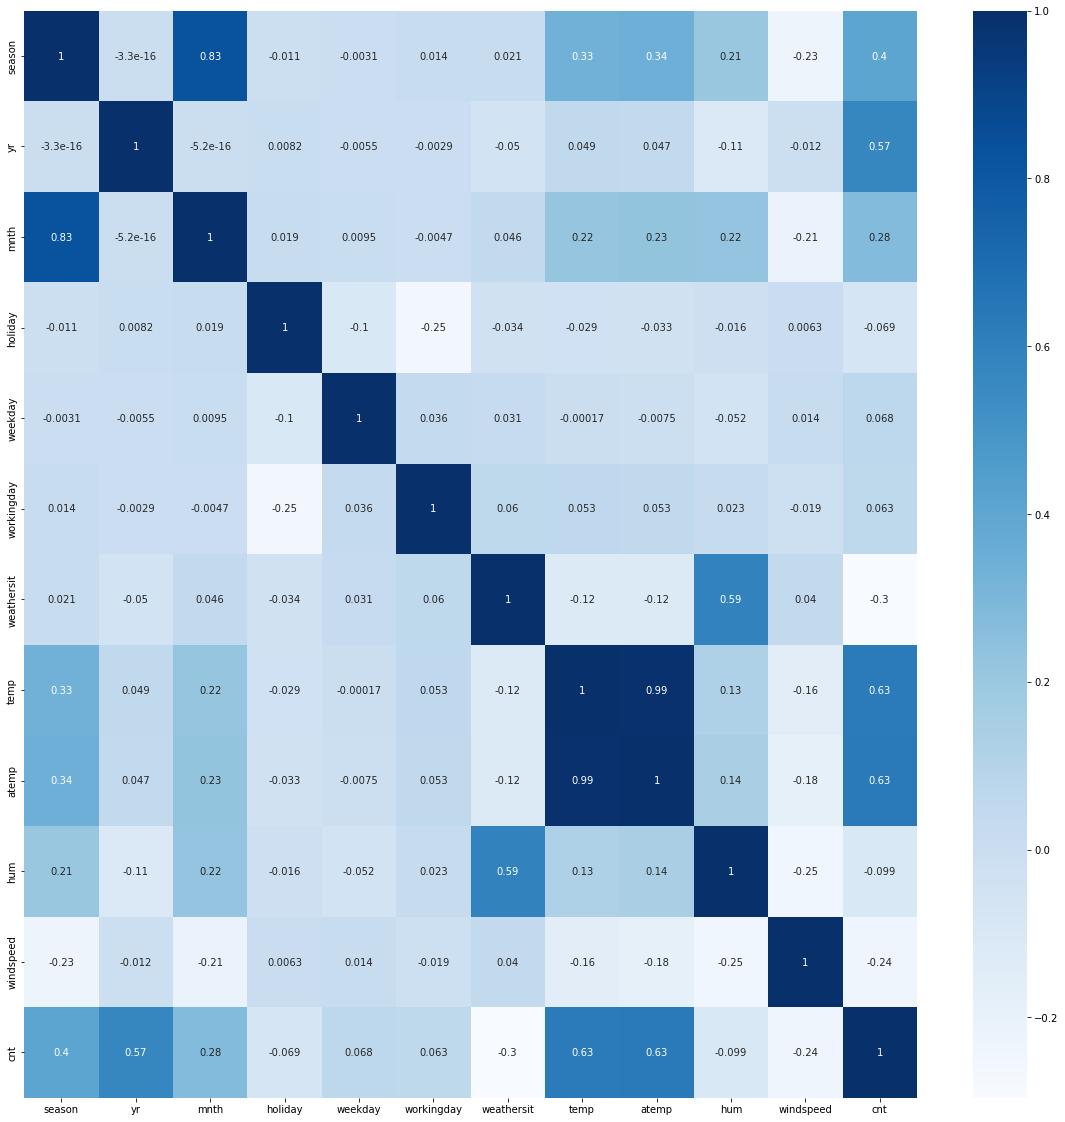

In [713]:
# Exploratory data analysis
eda = EDA()
eda.plot_corr(bike_data)

In [714]:
# From the heatmap, it can be inferred that temp and atemp are highly correlated. So one of them can be dropped as they are dependent on each other
# Bikes demand is mostly dependant on atemp,year,season
# Dropping temp as atemp is more relevant because it is the temperature that the user feels 
# It can be seen that even season and month are coorelated as they are dependant i.e you can predict the season from the month of the year
# Retaining season and dropping month as season is highly corelated to the output as compared to month
bike_data.drop(["temp","mnth"],axis=1,inplace=True)

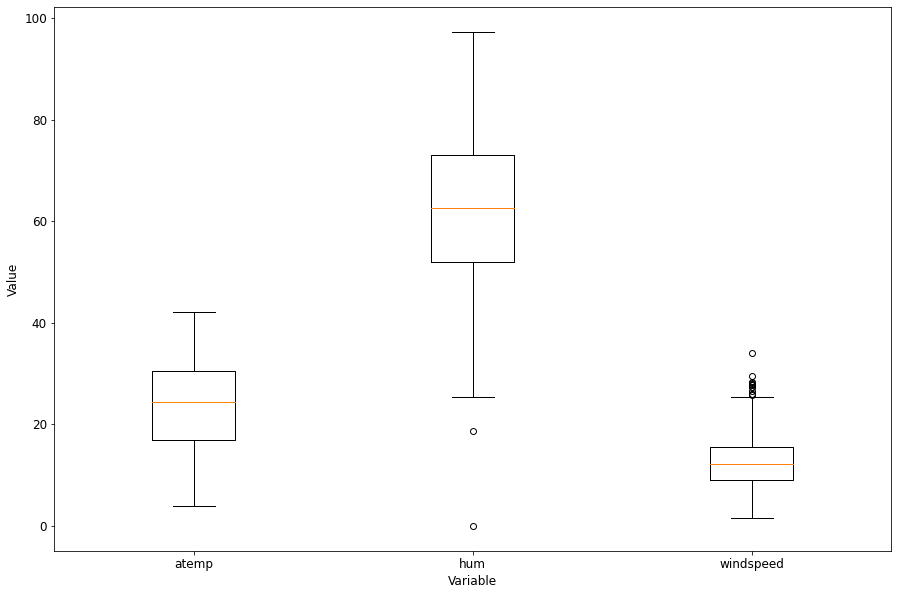

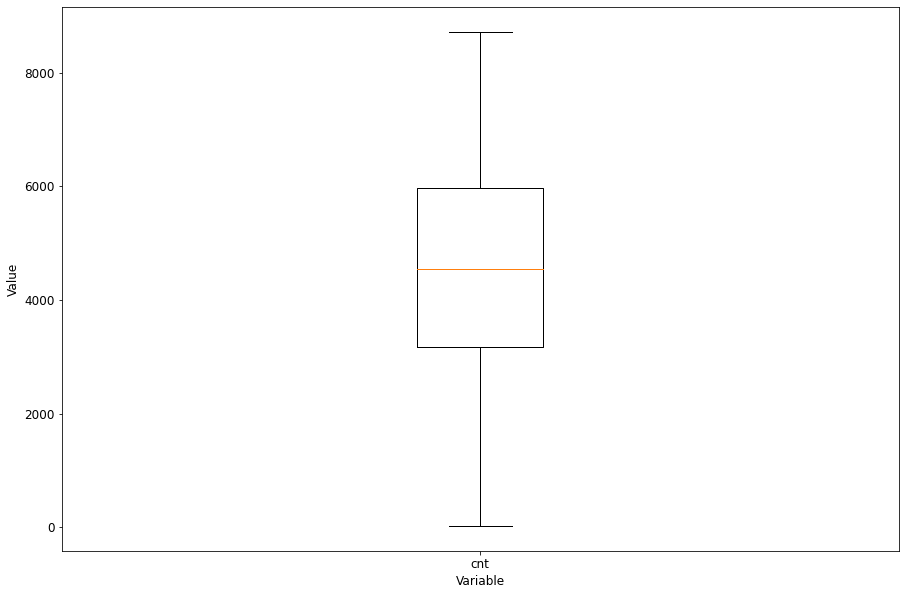

In [715]:
# Plotting box plot to detect outliers
eda.box_plot(bike_data,num_columns)
eda.box_plot(bike_data,["cnt"])

In [716]:
# It can be seen that variables hum and windspeed have outliers as per the standard outlier definition (univariate)
# No outliers are found in the target variable
# Checking the number of outliers
eda.detect_outliers(bike_data)

Number of outliers in column  atemp  are  0
Number of outliers in column  hum  are  2
Number of outliers in column  windspeed  are  13


In [717]:
# In linear regression, the outliers are removed based on both input and target variables
# So neglecting the outliers found from univariate analysis

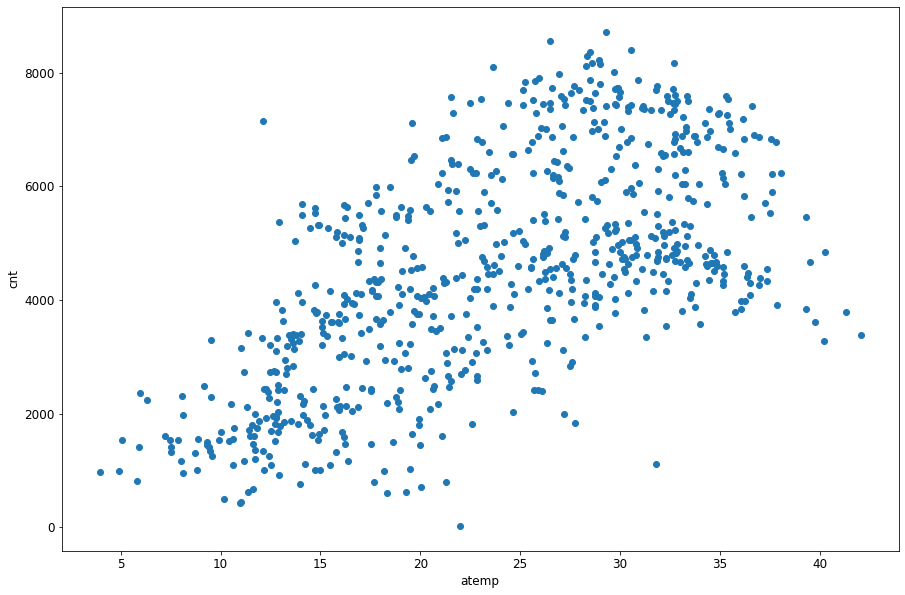

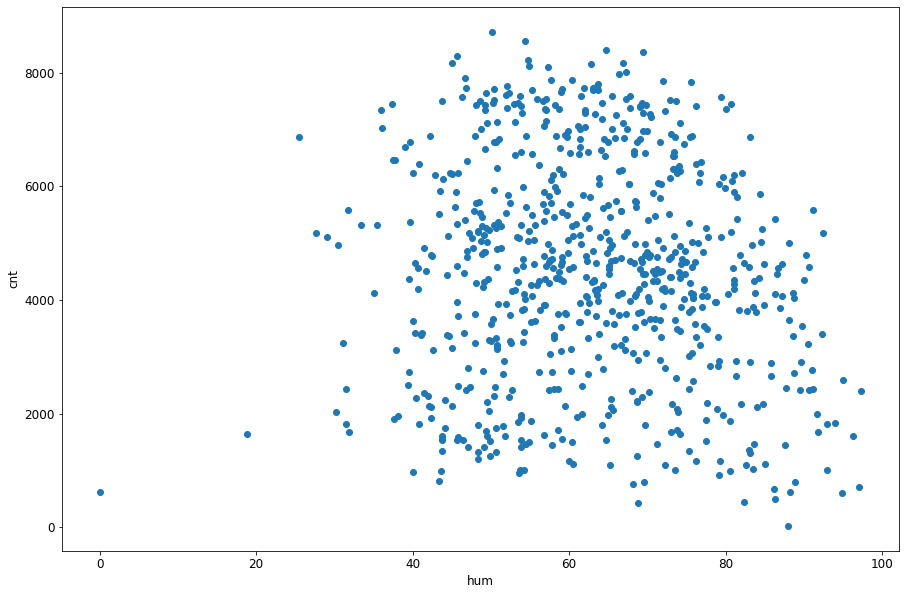

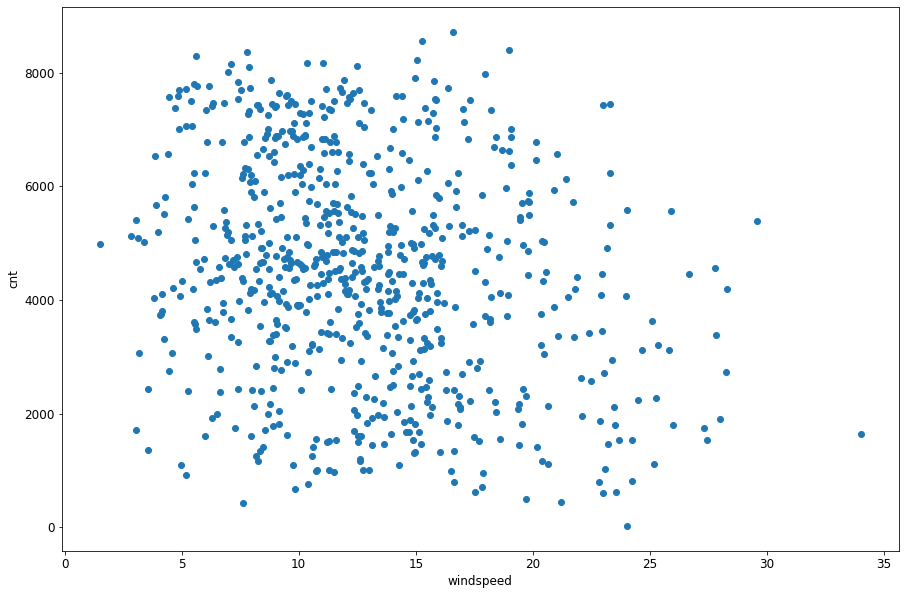

In [718]:
# Plotting scatter plot wrt target variable to detect outliers
eda.plot_scatter(bike_data)

In [719]:
# From the scatter plot it can be seen that some kind of positive linear relationship exists between atemp and cnt
# This was also observed from heatmap where the correlation coefficient was 0.63

In [720]:
# From the scatter plot we can see that there is some linear relationship between atemp and cnt
# There are some points in the scatter plot which are outliers
# Removing such points manually
removed_points = np.array([(12.12,7148),(31.77,1115),(21.97,22)])

In [721]:
# Removing outliers based on scatter plot cnt vs atemp
bike_data = bike_data[~(bike_data["cnt"].isin (removed_points[:,1]))]

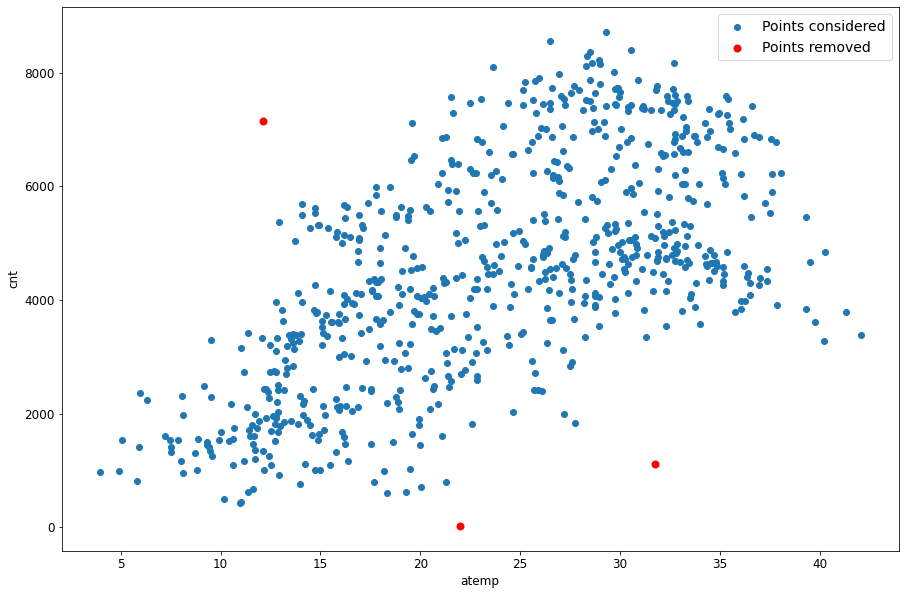

The number of points remaining after removing the outliers are  727


In [722]:
# Highlighting the points that are removed
eda.plot_scatter_with_removed(bike_data,"atemp",removed_points)

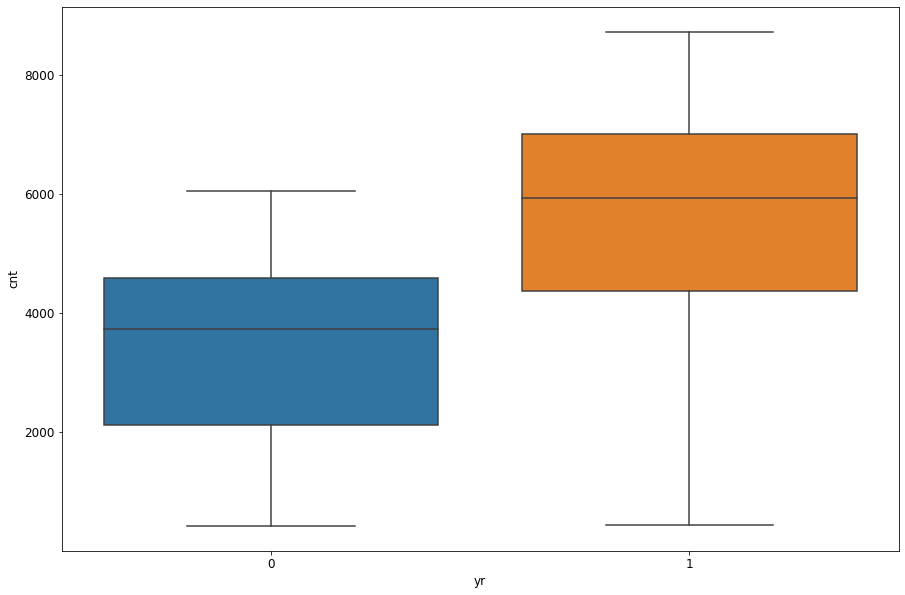

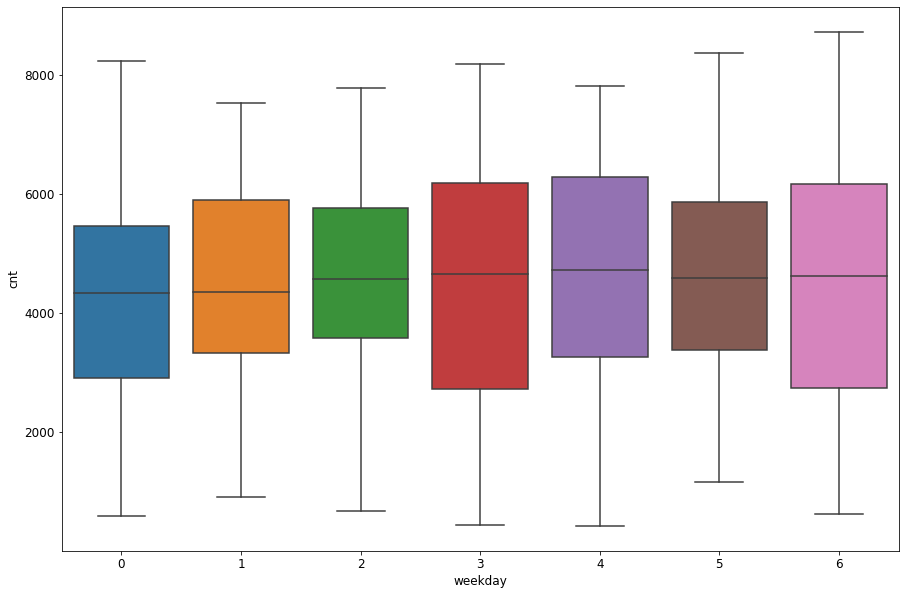

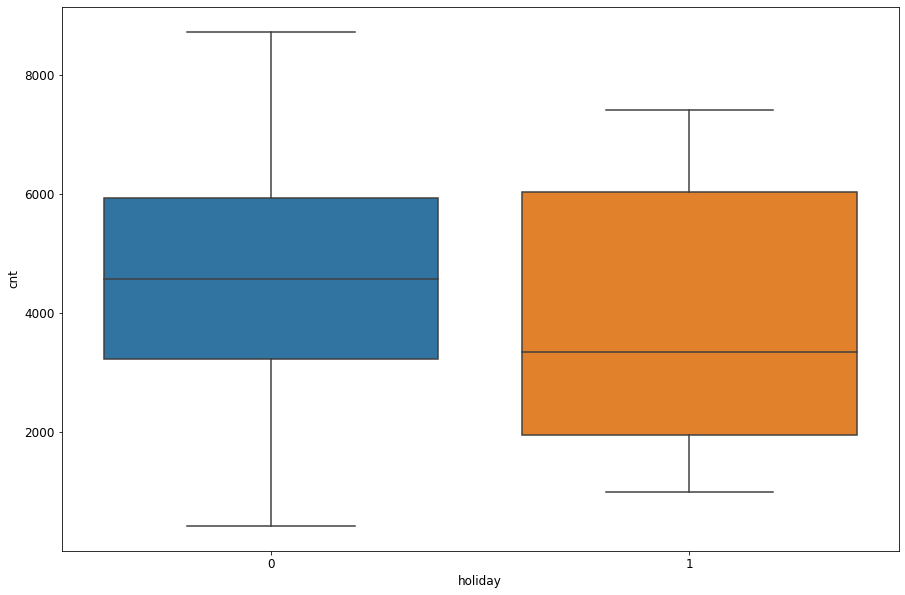

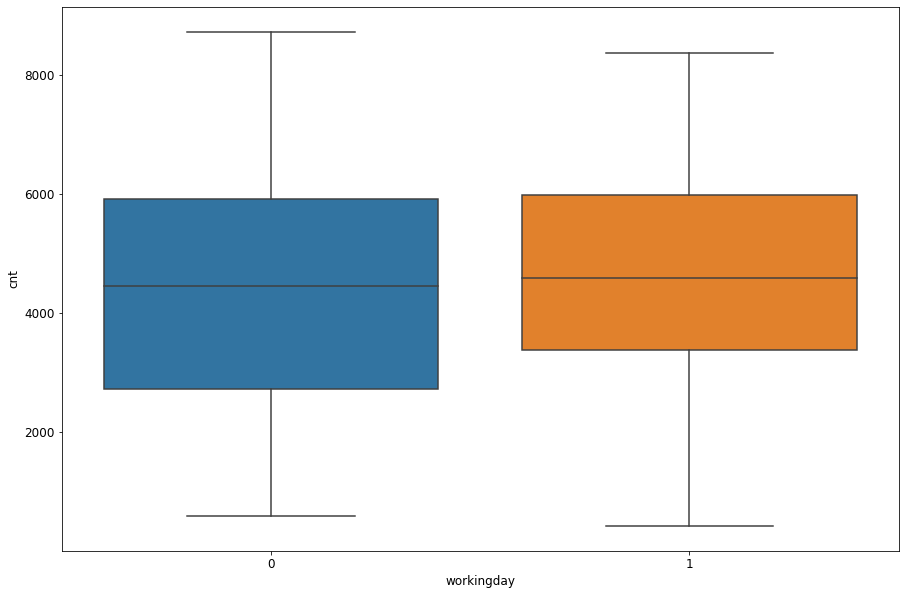

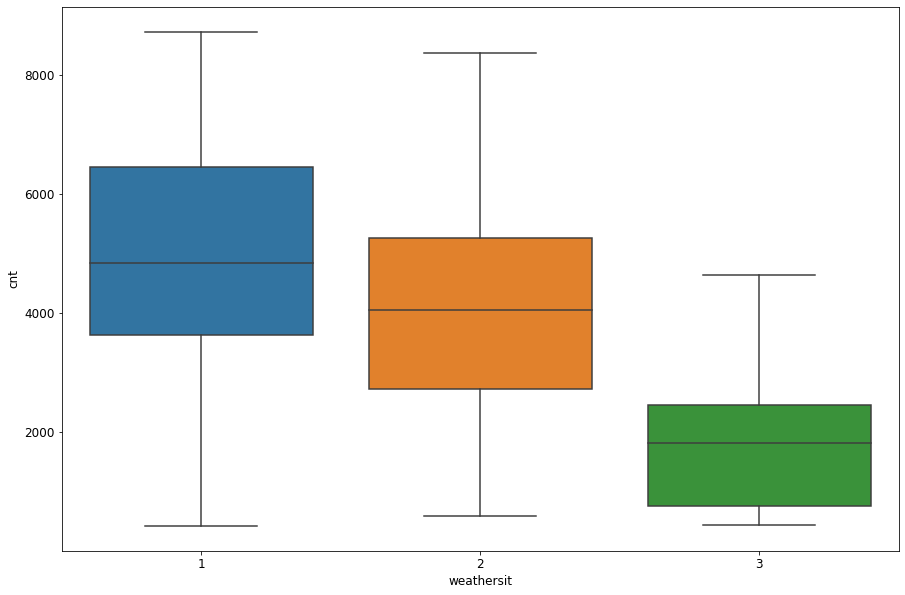

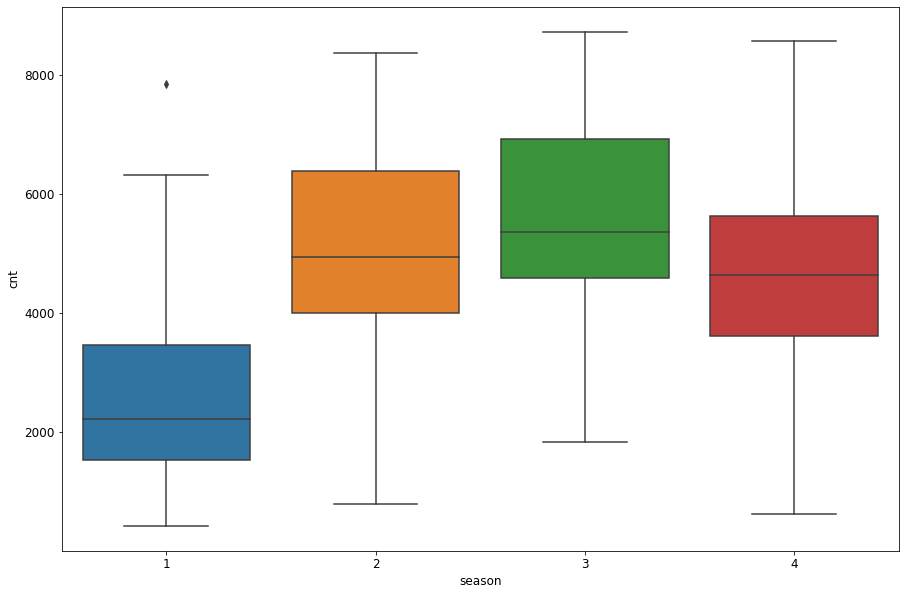

In [723]:
# Checking outliers wrt other variables and target variable
other_variables = ordered_cat + unordered_cat + ["season"]
for i in other_variables:
    eda.box_plot_cat(bike_data,i)

In [724]:
# Only outlier is found in season vs cnt plot in season 1
# Removing the point
bike_data=bike_data[~((bike_data["season"]==1) & (bike_data["cnt"]>7000))]


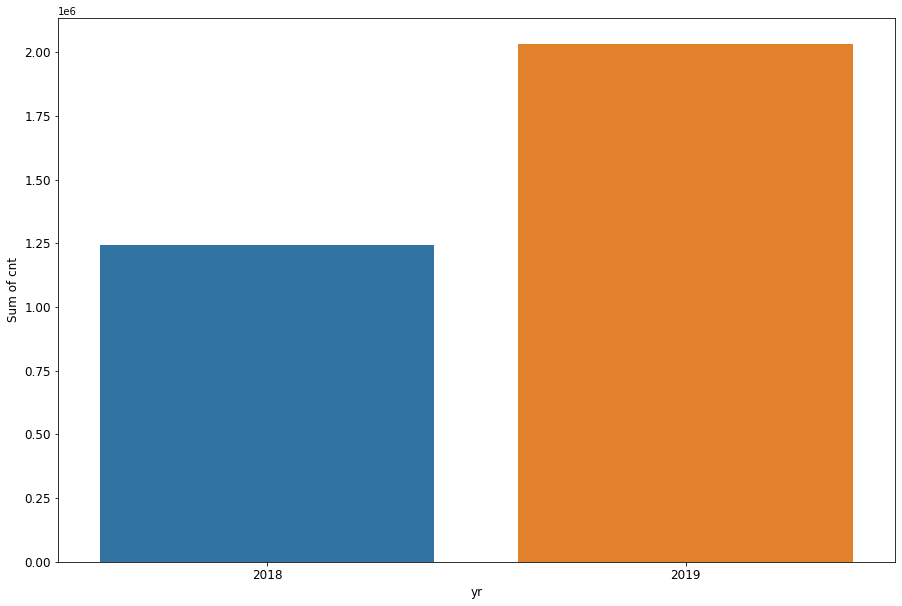

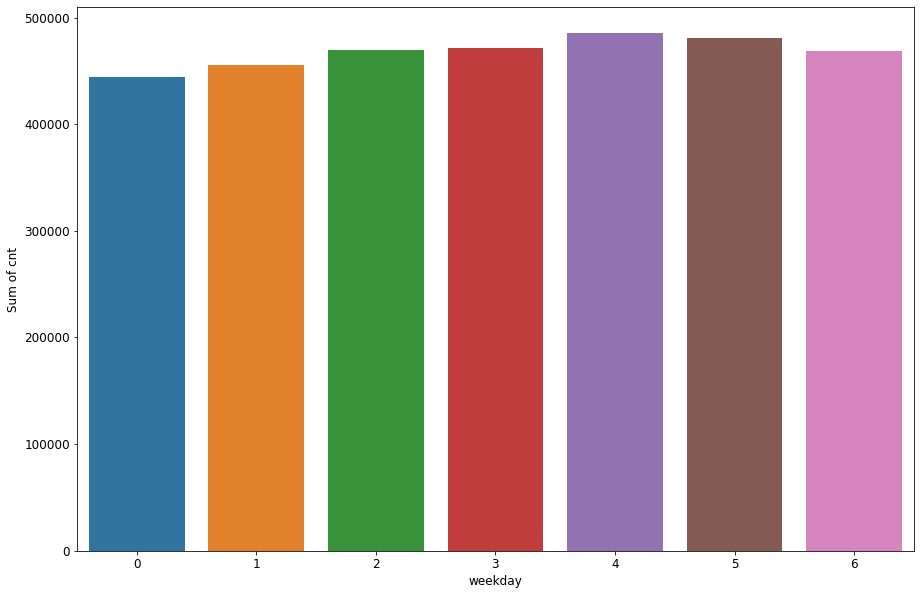

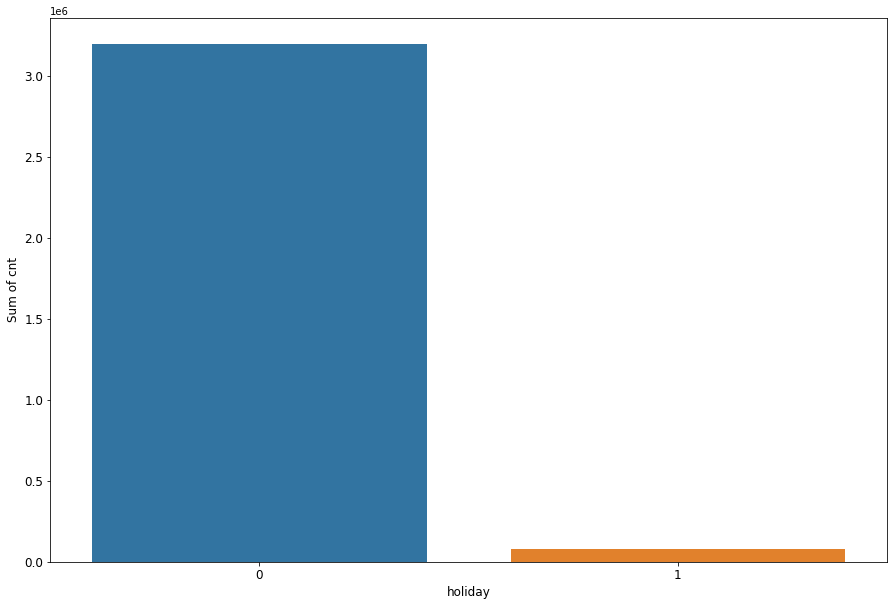

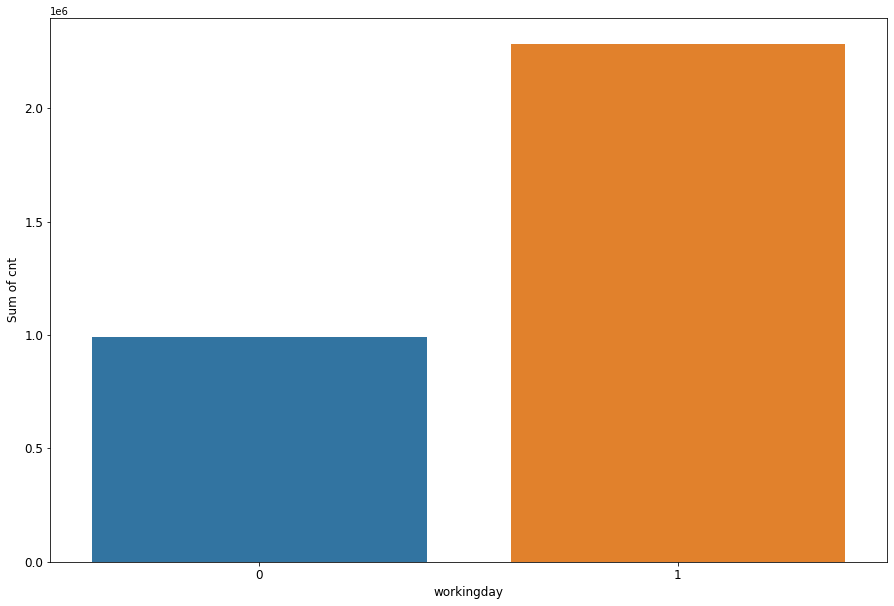

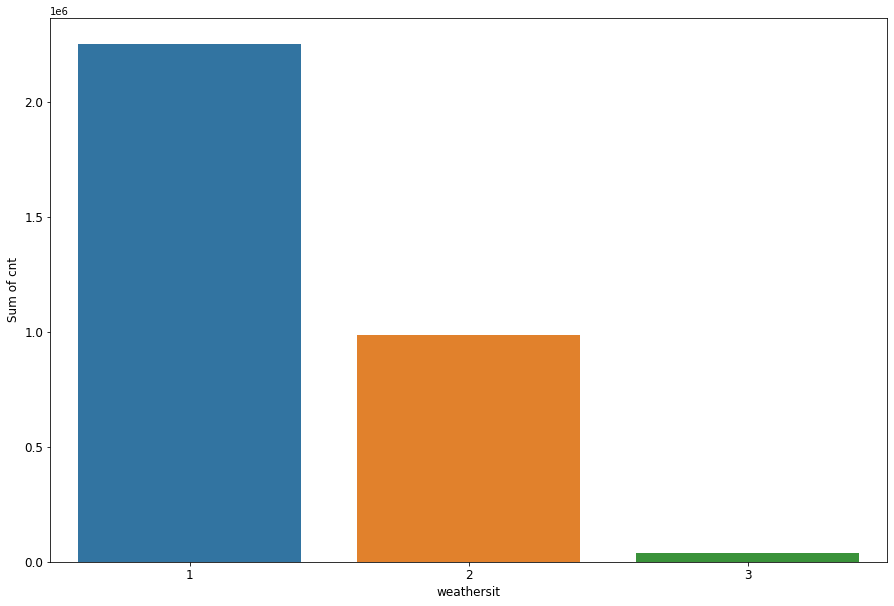

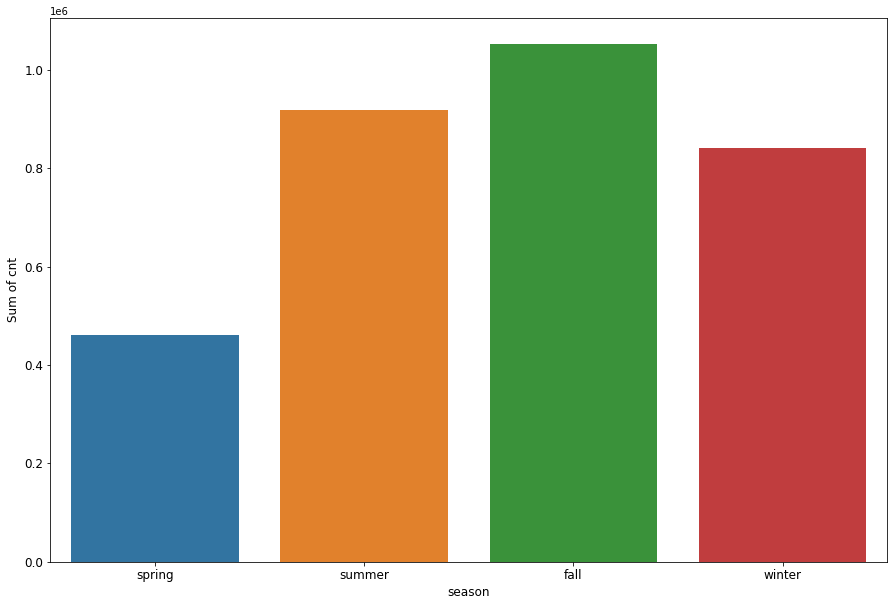

In [725]:
# Plotting bar plot wrt other variables
eda.plot_bar(bike_data,other_variables)

In [726]:
# Insights from EDA
# 1) atemp,year and season have high corelation with cnt - They might be the key variables in predicting the same
# 2) The demand of bikes has increases in 2019 comapred to 2018
# 3) The demand of bikes is almost the same for all the weekdays - Might nor contribute to cnt prediction
# 4) The demand is more on working days as compared to that of holidays 
# 5) The demand is more in clear weather conditions
# 6) The demand is more in fall and summer seasons

In [727]:
# Dealing with categorical variables
#  Ordered catregorical variables are being dealt using ordinal encoding
# In the given data set, ordered categorical variables are already in the form of numbers

In [728]:
# Dummy encoding for unordered categorical variables
# holiday and working day are already encoded
# Encoding weathersit
weather_enc = pd.get_dummies(bike_data["weathersit"],drop_first=True)
# Renaming the encoded columns for better understanding
weather_enc.rename(columns={2:"Mist",3:"Light_snow_rain"},inplace=True)
bike_data = pd.concat([bike_data,weather_enc],axis=1)
bike_data.drop(["weathersit"],axis=1,inplace=True)
bike_data.head()

,season,yr,holiday,weekday,workingday,atemp,hum,windspeed,cnt,Mist,Light_snow_rain
0,1,0,0,6,0,18.18125,80.5833,10.749882,985,1,0
1,1,0,0,0,0,17.68695,69.6087,16.652113,801,1,0
2,1,0,0,1,1,9.47025,43.7273,16.636703,1349,0,0
3,1,0,0,2,1,10.60610,59.0435,10.739832,1562,0,0
4,1,0,0,3,1,11.46350,43.6957,12.522300,1600,0,0


In [729]:
# Season is a cyclic variable and the bike sales can be high in a particular season. In order for the model to capture that this has to be encoded via dummy encoding
# Applying dummy encoding on column season to capture the effect of season
season_enc = pd.get_dummies(bike_data["season"],drop_first=True,prefix="Season")
bike_data = pd.concat([bike_data,season_enc],axis=1)
bike_data.drop(["season"],axis=1,inplace=True)
bike_data.head()

,yr,holiday,weekday,workingday,atemp,hum,windspeed,cnt,Mist,Light_snow_rain,Season_2,Season_3,Season_4
0,0,0,6,0,18.18125,80.5833,10.749882,985,1,0,0,0,0
1,0,0,0,0,17.68695,69.6087,16.652113,801,1,0,0,0,0
2,0,0,1,1,9.47025,43.7273,16.636703,1349,0,0,0,0,0
3,0,0,2,1,10.60610,59.0435,10.739832,1562,0,0,0,0,0
4,0,0,3,1,11.46350,43.6957,12.522300,1600,0,0,0,0,0


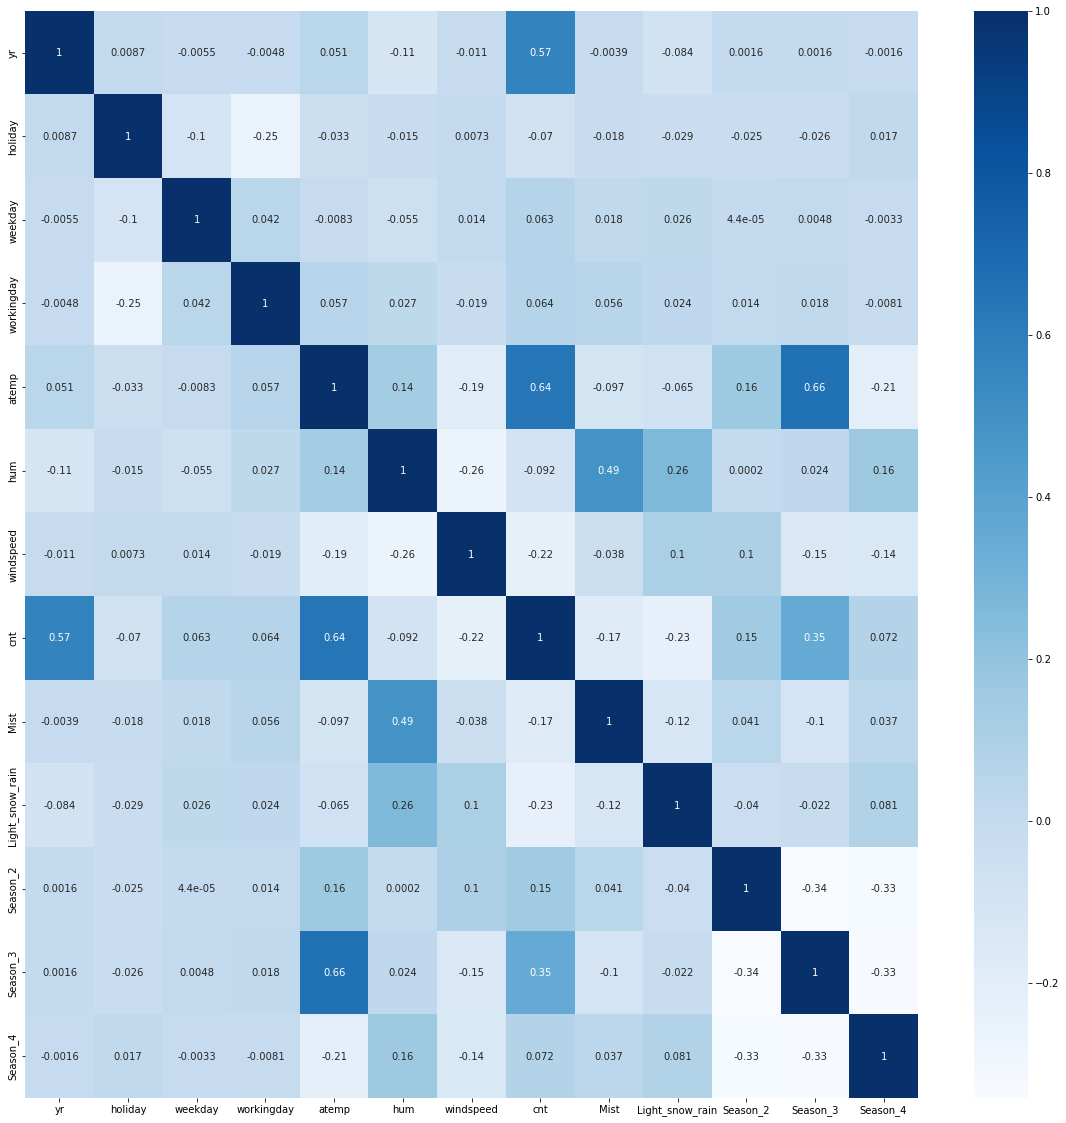

In [730]:
# Plotting heatmap for variables after dummy encoding
eda.plot_corr(bike_data)

In [731]:
# # Creating a seprate df by adding a constant to inputs for modelling intercept
bike_data["cnst"] = 1

In [732]:
# Splitting is done before scaling to avoid data leakage
# Splitting the data for training. Using 70 % data for training and 30 % data for testing
X,y = bike_data.drop(("cnt"),axis=1),bike_data["cnt"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [733]:
# Linear regression is independant of feature scaling
# Scaling the data for better interpretation of results
# Scaling the data using min max scaler
feat_scal = ["atemp","hum","windspeed"]
scaler = MinMaxScaler()
X_train[feat_scal] = scaler.fit_transform(X_train[feat_scal])
X_test[feat_scal] = scaler.transform(X_test[feat_scal])

C:\Users\kvc06\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
C:\Users\kvc06\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [734]:
# Defining class for all training related methods and attributes

class Model_build:

    def __init__(self,feat): # Instance attributes
        self.feat = feat
    
    def train_model(self): # Method to train linear regression model
        lin_reg = LinearRegression()
        lin_reg.fit(X_train[self.feat],y_train)
        self.trained_model = lin_reg
        self.y_train_pred = lin_reg.predict(X_train[self.feat])
        self.y_test_pred = lin_reg.predict(X_test[self.feat])
        self.r2_train = round(r2_score(y_train,self.y_train_pred),2)
        self.adj_r2_train = round(self.adj_r2(self.r2_train,len(self.feat),len(y_train)),2)
        self.r2_test = round(r2_score(y_test,self.y_test_pred),2)
        self.adj_r2_test = round(self.adj_r2(self.r2_test,len(self.feat),len(y_test)),2)
        print("The r2 score on the train set is ",self.r2_train)
        print("The adjusted r2 score on the train set is ",self.adj_r2_train)
        print("The r2 score on the test set is ",self.r2_test)
        print("The adjusted r2 score on the test set is ",self.adj_r2_test)
    

    def adj_r2(self,r2,nfeat,n): # Method to find adjusted r2
        adjr_2 = 1-(1-r2)*(n-1)/(n-nfeat-1)
        return adjr_2

    def plot_predictions(self,actual,predicted,label_name): # Method to plot predictions
        plt.figure(figsize=(15,10))
        plt.plot(actual,actual,linewidth=3,color="green")
        plt.scatter(actual,predicted,marker="x",color="black")
        plt.legend(("Actual data","Model prediction"),fontsize=16)
        plt.xlabel("cnt",fontsize=12)
        plt.ylabel("cnt",fontsize=12)
        plt.title("Actual vs Model on "+ label_name + " set",fontsize=20)
        if label_name=="train":
            plt.text(1000,7000,"R2: " + str(self.r2_train),fontsize="large")
        else:
            plt.text(1000,7000,"R2: " + str(self.r2_test),fontsize="large")
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.show()

    def plot_residual(self): # Method to plot
        plt.figure(figsize=(15,10))
        sns.distplot(y_train-self.y_train_pred,bins=50)
        plt.xlabel("Residual",fontsize=12)
        plt.ylabel("Density",fontsize=12)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.show()

    def calc_vif(self):
        if len(self.feat)<=1:
            print("Cannot calculate VIF as only one feature is present")
        else:
            self.vif_data = pd.DataFrame()
            self.vif_data["Features"]=self.feat
            self.vif_data["VIF_values"] =  [variance_inflation_factor(X_train[self.feat].values, i) for i in range(len(self.feat))]
            self.vif_data = self.vif_data.sort_values(by="VIF_values",ascending=False)
            print(self.vif_data)

    def sig_check(self):
        feat_with_cnst = self.feat + ["cnst"]
        model = sm.OLS(y_train,X_train[feat_with_cnst])
        reg = model.fit()
        print(reg.summary())
        

The r2 score on the train set is  0.39
The adjusted r2 score on the train set is  0.39
The r2 score on the test set is  0.45
The adjusted r2 score on the test set is  0.45


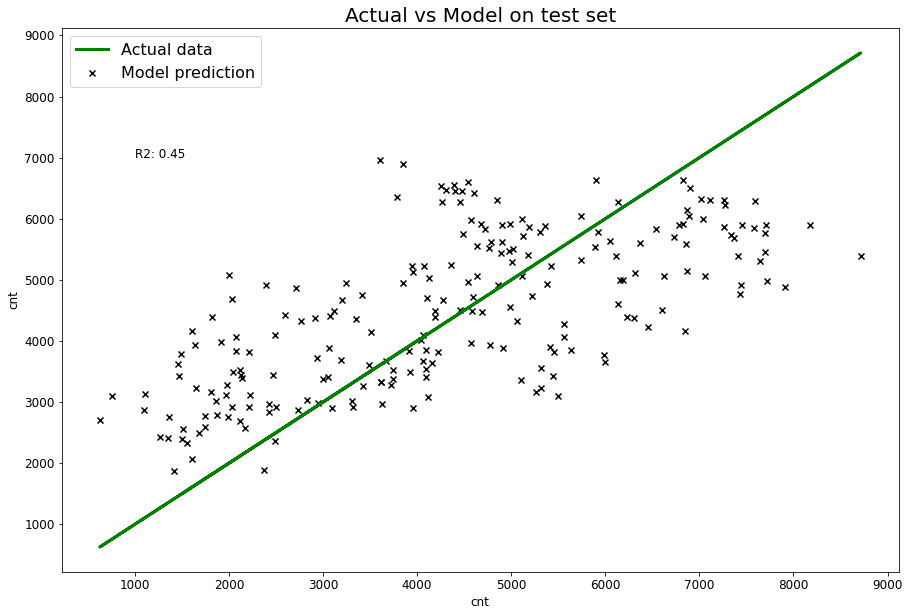

Cannot calculate VIF as only one feature is present


In [735]:
# Building the model using bottom up approach using corelation values
# Building the model using only atemp
sel_feat = ["atemp"]
model_1 = Model_build(sel_feat)
model_1.train_model()
model_1.plot_predictions(y_test,model_1.y_test_pred,"test")
model_1.calc_vif()


The r2 score on the train set is  0.68
The adjusted r2 score on the train set is  0.68
The r2 score on the test set is  0.76
The adjusted r2 score on the test set is  0.76


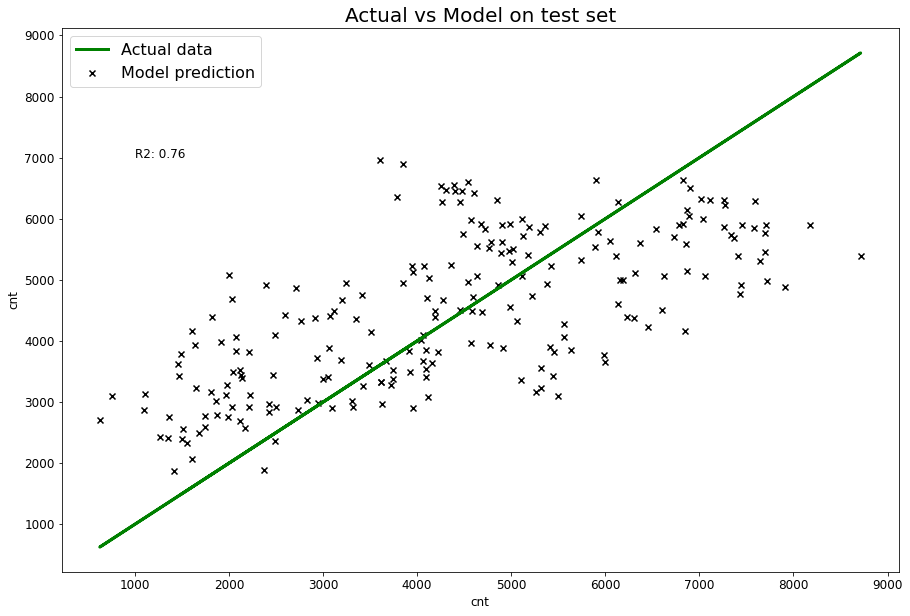

  Features  VIF_values
1       yr    1.831642
0    atemp    1.831642


In [736]:
# Building the model using bottom up approach using corelation values
# Building the model using only atemp
sel_feat = ["atemp","yr"]
model_2 = Model_build(sel_feat)
model_2.train_model()
model_2.plot_predictions(y_test,model_1.y_test_pred,"test")
model_2.calc_vif()

The r2 score on the train set is  0.68
The adjusted r2 score on the train set is  0.68
The r2 score on the test set is  0.76
The adjusted r2 score on the test set is  0.76


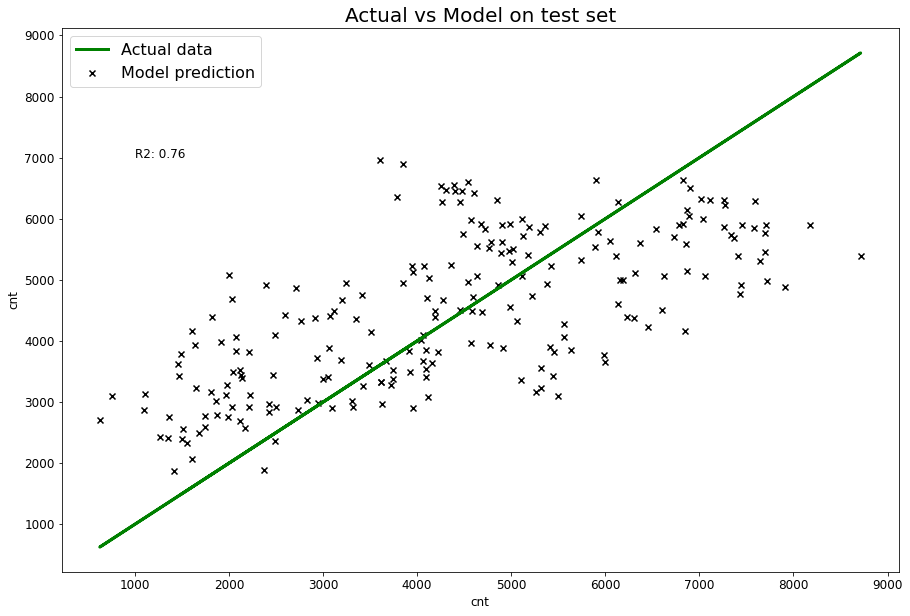

   Features  VIF_values
0     atemp    2.218797
1        yr    1.831730
2  Season_2    1.395094


In [737]:
# Building the model using bottom up approach using corelation values
# Building the model using only atemp
sel_feat = ["atemp","yr","Season_2"]
model_3 = Model_build(sel_feat)
model_3.train_model()
model_3.plot_predictions(y_test,model_1.y_test_pred,"test")
model_3.calc_vif()

The r2 score on the train set is  0.75
The adjusted r2 score on the train set is  0.75
The r2 score on the test set is  0.79
The adjusted r2 score on the test set is  0.79


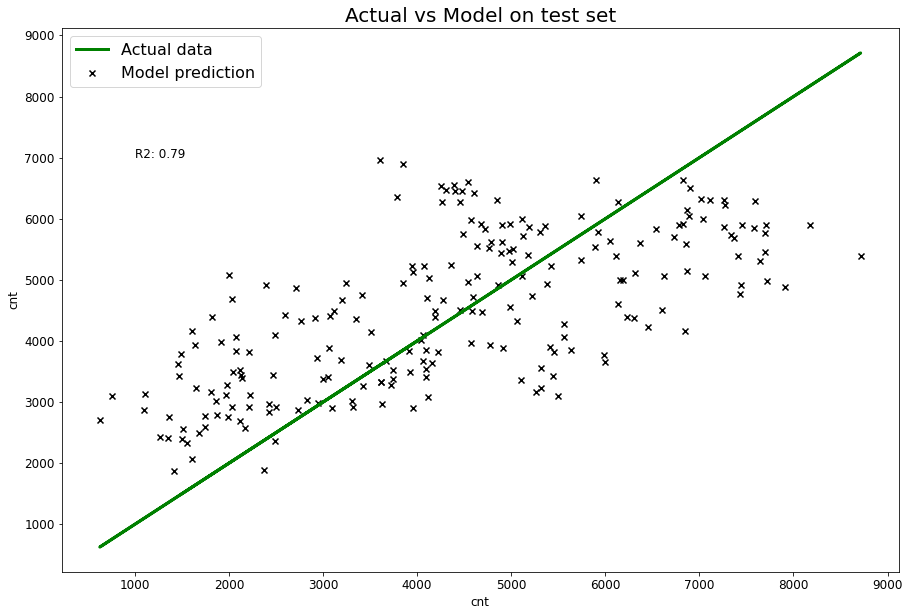

   Features  VIF_values
0     atemp    2.459254
1        yr    1.879896
2  Season_2    1.511092
3  Season_4    1.317659


In [738]:
# Building the model using bottom up approach using corelation values
# Building the model using only atemp
sel_feat = ["atemp","yr","Season_2","Season_4"]
model_4 = Model_build(sel_feat)
model_4.train_model()
model_4.plot_predictions(y_test,model_1.y_test_pred,"test")
model_4.calc_vif()

The r2 score on the train set is  0.77
The adjusted r2 score on the train set is  0.77
The r2 score on the test set is  0.82
The adjusted r2 score on the test set is  0.82


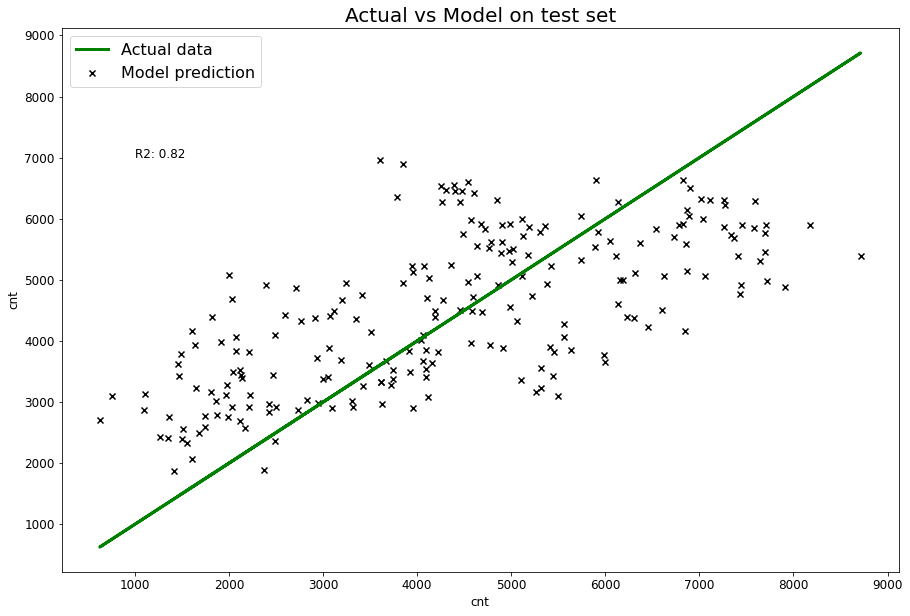

          Features  VIF_values
0            atemp    2.467971
1               yr    1.882024
2         Season_2    1.513220
3         Season_4    1.321365
4  Light_snow_rain    1.016354


In [739]:
# Building the model using bottom up approach using corelation values
# Building the model using only atemp
sel_feat = ["atemp","yr","Season_2","Season_4","Light_snow_rain"]
model_5 = Model_build(sel_feat)
model_5.train_model()
model_5.plot_predictions(y_test,model_1.y_test_pred,"test")
model_5.calc_vif()

The r2 score on the train set is  0.79
The adjusted r2 score on the train set is  0.79
The r2 score on the test set is  0.83
The adjusted r2 score on the test set is  0.83


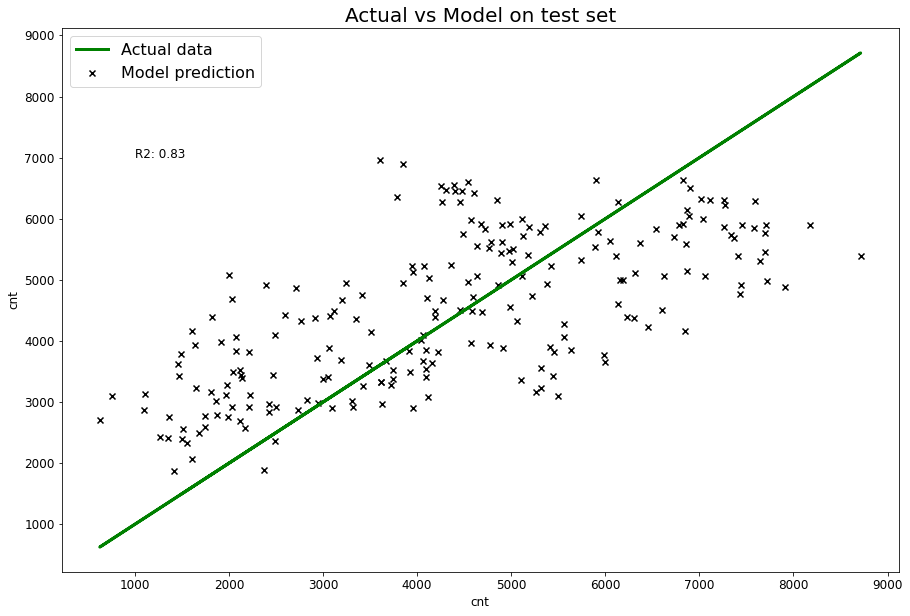

          Features  VIF_values
0            atemp    2.679249
1               yr    1.888310
2         Season_2    1.527264
5             Mist    1.442424
3         Season_4    1.351111
4  Light_snow_rain    1.022468


In [740]:
sel_feat = ["atemp","yr","Season_2","Season_4","Light_snow_rain","Mist"]
model_6 = Model_build(sel_feat)
model_6.train_model()
model_6.plot_predictions(y_test,model_1.y_test_pred,"test")
model_6.calc_vif()

The r2 score on the train set is  0.82
The adjusted r2 score on the train set is  0.82
The r2 score on the test set is  0.8
The adjusted r2 score on the test set is  0.79


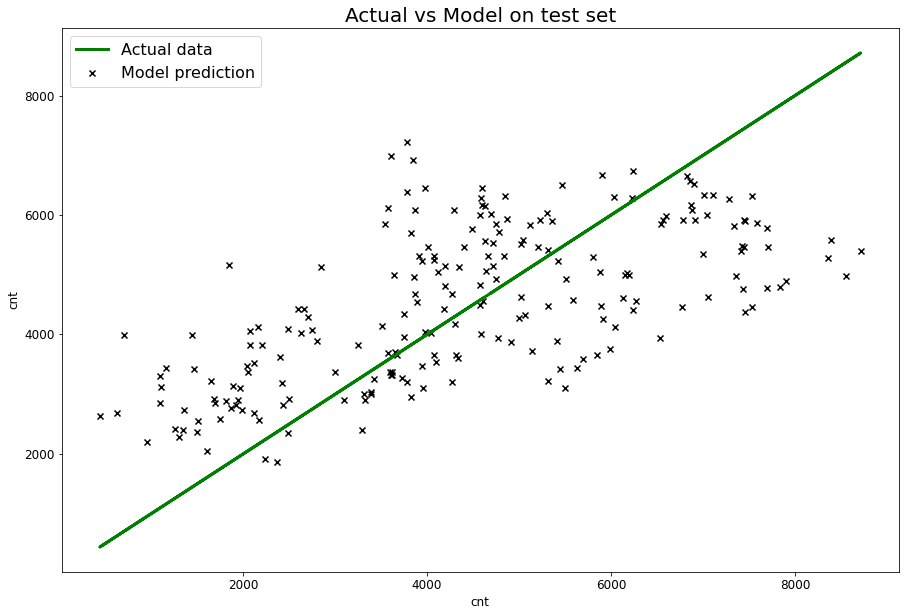

          Features  VIF_values
0            atemp   11.633768
6         Season_3    5.648744
2         Season_2    3.886954
3         Season_4    2.477565
1               yr    1.972321
5             Mist    1.447043
4  Light_snow_rain    1.042415


In [436]:
# sel_feat = ["atemp","yr","Season_2","Season_4","Light_snow_rain","Mist"]
# model_7 = Model_build(sel_feat)
# model_7.train_model()
# model_7.plot_predictions(y_test,model_1.y_test_pred,"test")
# model_7.calc_vif()

In [203]:
# rel_feat = list(X_train.columns[rfe.support_]) # list of relevant features
# #rel_feat = ["Season_2","Season_3"Season_3","yr","atemp","Light_snow_rain"]
# rel_feat.append("constant") # adding constant term for stats module
# #rel_feat.remove("atemp")
# #rel_feat.remove("mnth")

In [204]:
# Calculating the vif values to check for co-linearity
# vif_data = pd.DataFrame()
# vif_data["Features"]=rel_feat
# vif_data["values"] =  [variance_inflation_factor(X_train[rel_feat].values, i) for i in range(len(rel_feat))]
# print(vif_data)

In [205]:
# The VIF values of all the features is less than 5
# We can ignore constant while VIF calculation as it can obisiously be predicted by other variables
# So the features are not significantly related to each other

In [206]:
# Using stats module to predict cnt
# model = sm.OLS(y_train,X_train[rel_feat])
# reg = model.fit()
# reg.summary()

In [207]:
# The  probability of t score and f score is very almost 0
# So we can say that the features are significant

In [208]:
# Predicting on the train set for error evaluation
# y_train_pred = reg.predict(X_train[rel_feat])

In [209]:
# Plotting distribution of residuals
# plt.figure(figsize=(15,10))
# sns.distplot(y_train-y_train_pred,bins=50)
# plt.xlabel("Residual",fontsize=12)
# plt.ylabel("Density",fontsize=12)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.show()

In [210]:
# plt.figure(figsize=(15,10))
# plt.plot(y_test,y_test,linewidth=3,color="green")
# plt.scatter(y_train,y_train_pred,marker="x",color="black")
# plt.legend(("Actual data","Model prediction"),fontsize=16)
# plt.title("Actual vs Model on train set",fontsize=20)
# plt.xlabel("cnt",fontsize=12)
# plt.ylabel("cnt",fontsize=12)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.show()

In [211]:
# From the above plot it can be seen that the residuals follow a normal distribution with mean centered around 0
# From this we can conclude that the linear regression assumptions are valid

In [212]:
# r2 score on the test set
#X_test[feat_scal] = scaler.transform(X_test[feat_scal])
# y_test_pred = reg.predict(X_test[rel_feat])
# r2_score(y_test,y_test_pred)

In [213]:
# Plotting graph between model predictions and the actual values on test set
# plt.figure(figsize=(15,10))
# plt.plot(y_test,y_test,linewidth=3,color="green")
# plt.scatter(y_test,y_test_pred,marker="x",color="black")
# plt.legend(("Actual data","Model prediction"),fontsize=16)
# plt.xlabel("cnt",fontsize=12)
# plt.ylabel("cnt",fontsize=12)
# plt.title("Actual vs Model on test set",fontsize=20)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.show()

In [214]:
# From the above graph it can be seen that the preditions are almost randomly distributed wrt actual data


In [215]:
# Conclusion
# We were able to explain about 77% of variance using only 50 % of available data
# Important features in order: 
# 1) atemp - Feeling temperature - More the feeling temperature more is the demand for bikes 
# 2) yr - The demand for bikes is increasing year on year - The company should prepare themselves to meet higher demand of bikes
# 3) Light_snow_rain - Light rain or snow has a negtive impact on the demand of bikes - The company can focus on maintainence of existing bikes during such weather conditions
# 4) hum - Higher humidity leads to less demand for bikes
# 5) Season - The demand for bikes is more in summer and winter with winter demand almost double than that of the summer demand


In [216]:
# Further improvements to the model can be done by
# 1) Using a non linear model for higher demands as from the plot it can be seen that the model is under predicting for the values of demand > 7000
# 2) Using more number of data points